In [98]:
# importing the necessary libraries
import numpy as np
import random
import csv
import matplotlib.pyplot as plt
import pandas as pd

In [99]:
# agent class - Task 1.1
class Agent:
    def __init__(self, state_space, action_space, epsilon=0.1, alpha=0.5, gamma=0.9):
        """
            initializing the agent with the required parameters
            
            :param state_space: the number of states in the environment
            :param action_space: the number of possible actions in a single state
            :param epsilon: the probability for exploring new actions (set to a default value of 0.1)
            :param alpha: the learning rate which determines how much the agent updates its Q-values with new information (set to a default value of 0.5)
            :param gamma: the discount factor which determines the importance of future rewards (set to a default value of 0.9)
            
        """
        
        self.state_space = state_space
        self.action_space = action_space
        self.epsilon = epsilon
        self.alpha = alpha
        self.gamma = gamma
        self.q_table = self.initialize_q_table()
        
    
    def initialize_q_table(self):
        """
            Creating the agent's personal Q-Table for the environment
            The Q-table is represented in the form of a 2D numpy array of shape (state_space, action_space)
            Each row in the Q-Table represents a single state and each column represents a possible action within that space
            All the Q values in the table are initialized to 0
        """
        return np.zeros((self.state_space, self.action_space))
    
    def select_action(self, state):
        """
            Selects an action from the current state of the agent using the epsilon greedy approach
            
            :param state: Current state of the agent
            :return: Selected action
        """
        
        if random.uniform(0, 1) < self.epsilon:
            # explore - choose a random action from the current state
            return random.randint(0, self.action_space-1)
        else: 
            # exploit - choose the action with the max Q-value from the current state
            return np.argmax(self.q_table[state])
        
        
        
    def update_q_value(self, state, action, reward, next_state):
        """
            method updates the Q-value of the current state given a specific action using the Q-learning formula
            
            :param state: the current state of the agent
            :param action: the action to be taken from the current state
            :param reward: the immediate reward achieved by taking this action
            :param next_state: the state which is reached after taking this action
        """
        best_next_action = np.argmax(self.q_table[next_state])
        td_target = reward + self.gamma * self.q_table[next_state][best_next_action]
        td_error = td_target - self.q_table[state][action]
        self.q_table[state][action] += self.alpha * td_error
    

In [100]:
# grid class - Task 1.2
class Grid:
    
    def __init__(self, grid_size=10):
        self.grid_size = grid_size
        self.grid = np.full((self.grid_size, self.grid_size), -1, dtype=int)
        self.goal_position = (self.grid_size//2, self.grid_size//2)     # middle cell
        self.obstacles = [(3, 0),(4, 4),(7, 3),(9, 6)]
        
        # marking the goal on the grid
        self.grid[self.goal_position] = 20
        
        # marking the obstacles with a negative value that represent an 'unreachable' state
        for obstacle in self.obstacles:
            self.grid[obstacle] = -100
      
            
    def get_reward(self, position):
        """
            returns the reward for entering a specific grid cell
            checks if the position is valid before accessing the grid
            
            :param position: tuple (row, column) of the agent's current position
            :return: the cell's reward
        """
        if not self.is_valid_position(position):
            return -100
        
        return self.grid[position]
    
    
    def is_valid_position(self, position):
        """
            checks if a position is within the grid 
            obstacles are considered invalid positions
        """
        row, col = position
        if 0 <= row < self.grid_size and 0 <= col < self.grid_size:
            return self.grid[position] != -100
        
        return False
    
    
    def move_agent(self, current_position, action):
        """
            moves the agent on the grid based on the provided action
            if the new position is invalid (obstacle or out of bounds) then agent will stay in its position
            
            :param current_position: tuple (row, col) representing the current position of the agent on the grid
            :param action: integer value representing the action to be taken (0: up, 1: down, 2: left, 3: right)
            
            :return: new position of the agent
        """
        
        row, col = current_position
        moves = {
            0: (-1, 0),
            1: (1, 0),
            2: (0, -1),
            3: (0, 1)
        }
        
        dr, dc = moves[action] 
        new_position = (row + dr, col + dc)
        
        # check if the new position is valid
        if self.is_valid_position(new_position):
            return new_position
        
        # if the new position is invalid, stay in the current one
        return current_position
    
    
    def display_grid(self, agent_position=None):
        display_grid = self.grid.copy()
        if agent_position and self.is_valid_position(agent_position):
            display_grid[agent_position] = 99      # this marks a unique number for the agent
        print(display_grid)
        
    

In [101]:
# Simulate Learning - Task 2.1
def single_agent_simulation(grid_size=10, episodes=1000, save_path="single_agent_results.csv"):
    
    # initialize the environment and the agent
    env = Grid(grid_size=grid_size)
    agent = Agent(state_space=grid_size * grid_size, action_space=4, epsilon=0.8)
    
    # decaying the exploration over time in favor of exploitation
    epsilon_decay_rate = 0.99
    
    # metrics to track - episode number, reward, episode length
    results = []
    
    for episode in range(episodes):
        current_position = (0, 0)       # start at top left corner
        total_reward = 0
        steps = 0
        agent.epsilon = max(0.1, agent.epsilon * epsilon_decay_rate)
        
        while current_position != env.goal_position:
            
            # convert the agent's position to the state index in Q-table
            state_index = current_position[0] * grid_size + current_position[1]
            
            # agent selects an action
            action = agent.select_action(state_index)
            
            # environment will then process the agent's move
            new_position = env.move_agent(current_position, action)
            reward = env.get_reward(new_position)
            
            # update the Q-Value of this state action pair in the agent's Q-table
            new_state_index = new_position[0] * grid_size + new_position[1]
            agent.update_q_value(state_index, action, reward, next_state=new_state_index)
            
            # update the current position and the other metrics
            current_position = new_position
            total_reward += reward
            steps += 1
            
        # record the metrics for a single episode
        results.append((episode+1, total_reward, steps))
        
        
    # save the results of the single agent simulation to a csv file
    with open(save_path, mode="w", newline="") as file:
        writer = csv.writer(file)
        writer.writerow(["Episode", "Total Reward", "Episode Length"])
        writer.writerows(results)
    
    print(f"Simulation has completed. Results saved to {save_path}.")
    
            
    
    
    

In [102]:
# running a single simulation for 200, 800, and 1000 episodes
single_agent_simulation(episodes=200, save_path="single_agent_results_200.csv")
single_agent_simulation(episodes=800, save_path="single_agent_results_800.csv")
single_agent_simulation(episodes=1000, save_path="single_agent_results_1000.csv")


Simulation has completed. Results saved to single_agent_results_200.csv.
Simulation has completed. Results saved to single_agent_results_800.csv.
Simulation has completed. Results saved to single_agent_results_1000.csv.


In [103]:
# Task 2.2 - Multi-Agent Simulation
def multi_agent_simulation(grid_size=10, episodes=1000, save_path="multi_agent_results.csv"):
    
    # initialize environment
    env = Grid(grid_size=grid_size)
    
    # initialize agents
    agents = []
    for _ in range(4):
        agents.append(Agent(state_space=grid_size * grid_size, action_space=4, epsilon=0.8))
        
    # decaying the exploration over time in favor of exploitation
    epsilon_decay_rate = 0.99
        
    # possible starting agent positions for agents 1, 2, 3, and 4
    starting_positions = [(0, 0), (0, grid_size-1), (grid_size-1, 0), (grid_size-1, grid_size-1)]
    
    # metrics to track - episode number, rewards of each agent in an episode, final positions of the agents
    results = []
    for episode in range(episodes):
         # decay each agent's epsilon once per episode
        for agent in agents:
            agent.epsilon = max(0.1, agent.epsilon * epsilon_decay_rate)
        
        # resetting agent positions to new starting positions on the grid
        random.shuffle(starting_positions)
        positions = starting_positions[:4]
        
        # metrics to be tracked per episode
        total_rewards = [0] * 4     
        steps = [0] * 4
        current_steps = 0
        completed = [False] * 4
        
        while not all(completed):
            current_steps += 1
            
            for i, agent in enumerate(agents):
                if completed[i]: continue       # if the agent has already reached the goal
                
                current_position = positions[i]
                state_index = current_position[0] * grid_size + current_position[1]
                
                # agent selects an action
                action = agent.select_action(state_index)
                
                # environment process the move
                new_position = env.move_agent(current_position,action)
                reward = env.get_reward(new_position)
                
                # update the agent's Q-value
                new_state_index = new_position[0] * grid_size + new_position[1]
                agent.update_q_value(state_index, action, reward, next_state=new_state_index)    
                
                # update agent's position and other metrics
                positions[i] = new_position
                total_rewards[i] += reward
                steps[i] += 1
                
                # check if the agent has reached the goal
                if new_position == env.goal_position:
                    completed[i] = True
            
            
        # store the results for an episode
        results.append({
            "Episode": episode+1,
            "Episode Length": current_steps,
            "Steps": steps,
            "Agent 1 Reward": total_rewards[0],
            "Agent 2 Reward": total_rewards[1],
            "Agent 3 Reward": total_rewards[2],
            "Agent 4 Reward": total_rewards[3],
            "Final Positions": positions
        })
            
    with open(save_path, mode="w", newline="") as file:
        fieldnames = ["Episode", "Episode Length", "Steps", "Agent 1 Reward", "Agent 2 Reward", "Agent 3 Reward", "Agent 4 Reward", "Final Positions"]
        writer = csv.DictWriter(file, fieldnames=fieldnames)
        writer.writeheader()
        writer.writerows(results)
            
    print(f"Multi-Agent simulaiton complete. Results saved to {save_path}")
        

In [104]:
# running a multi-agent simulation with independent Q-Tables for 200, 800, and 1000 episodes
multi_agent_simulation(episodes=200, save_path="multi_agent_results_200.csv")
multi_agent_simulation(episodes=800, save_path="multi_agent_results_800.csv")
multi_agent_simulation(episodes=1000, save_path="multi_agent_results_1000.csv")


Multi-Agent simulaiton complete. Results saved to multi_agent_results_200.csv
Multi-Agent simulaiton complete. Results saved to multi_agent_results_800.csv
Multi-Agent simulaiton complete. Results saved to multi_agent_results_1000.csv


In [105]:
def analyze_results(single_agent_file, multi_agent_file):
    # load the data
    single_agent_data = pd.read_csv(single_agent_file)
    multi_agent_data = pd.read_csv(multi_agent_file)
    
    
    # analyzing the singel agent simulation
    plt.figure(figsize=(10, 6))
    plt.plot(single_agent_data["Episode"], single_agent_data["Total Reward"], label="Total Reward")
    plt.title("Single-Agent Learning Curve: Total Reward vs. Episode")
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.legend()
    plt.grid()
    plt.show()
    
    plt.figure(figsize=(10, 6))
    plt.plot(single_agent_data["Episode"], single_agent_data["Episode Length"], label="Episode Length", color="orange")
    plt.title("Single-Agent Learning Curve: Episode Length vs. Episode")
    plt.xlabel("Episode")
    plt.ylabel("Episode Length")
    plt.legend()
    plt.grid()
    plt.show()


    # analyzing the multi-agent simulation
    plt.figure(figsize=(10, 6))
    for i in range(1, 5):
        plt.plot(multi_agent_data["Episode"], multi_agent_data[f"Agent {i} Reward"], label=f"Agent {i}")
    plt.title("Multi-Agent Learning (Independent Q-Tables): Total Reward vs. Episode")
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.legend()
    plt.grid()
    plt.show()
    
    plt.figure(figsize=(10, 6))
    plt.plot(multi_agent_data["Episode"], multi_agent_data["Episode Length"], label="Episode Length", color="orange")
    plt.title("Multi-Agent Learning Curve: Episode Length vs. Episode")
    plt.xlabel("Episode")
    plt.ylabel("Episode Length")
    plt.legend()
    plt.grid()
    plt.show()

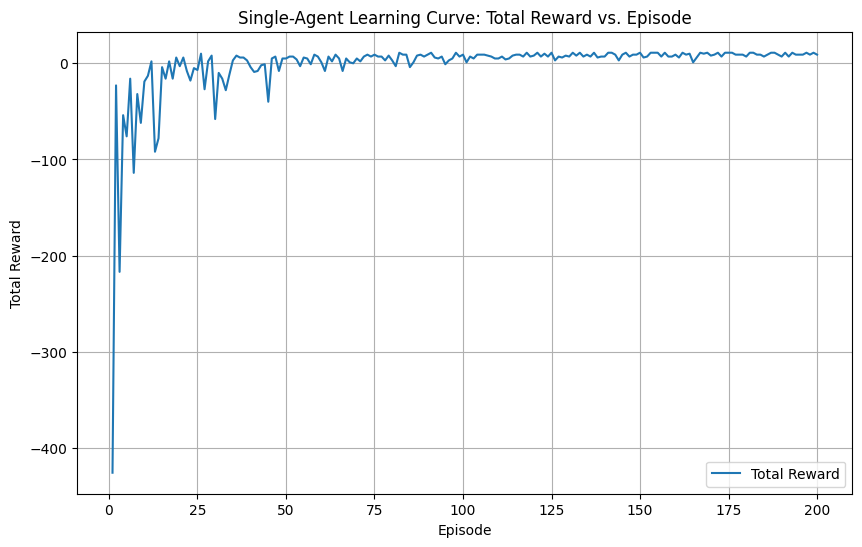

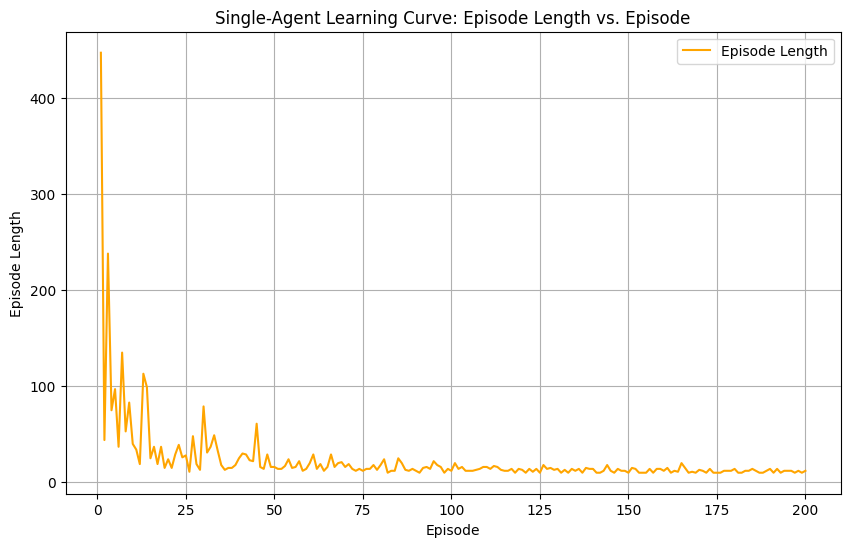

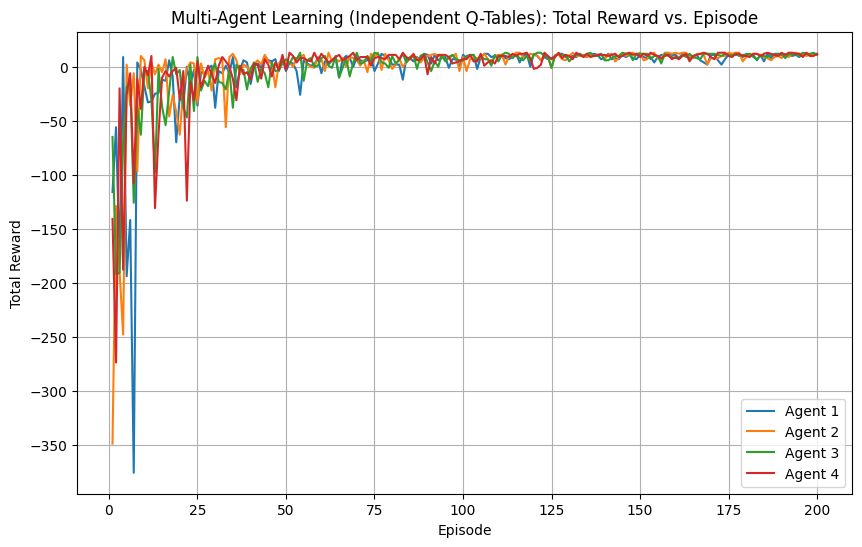

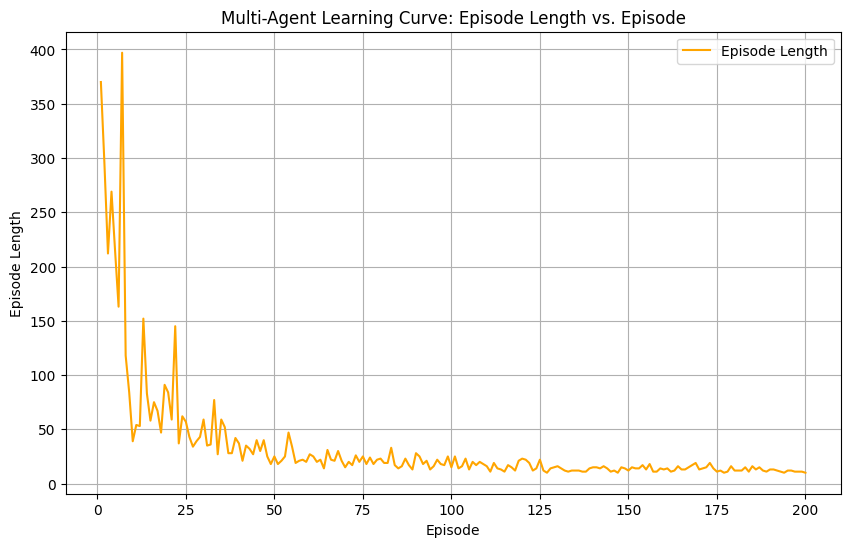

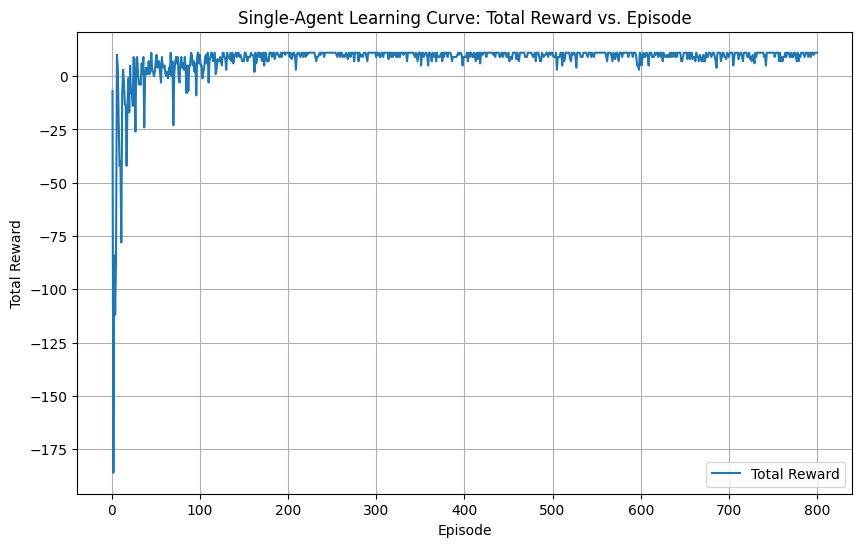

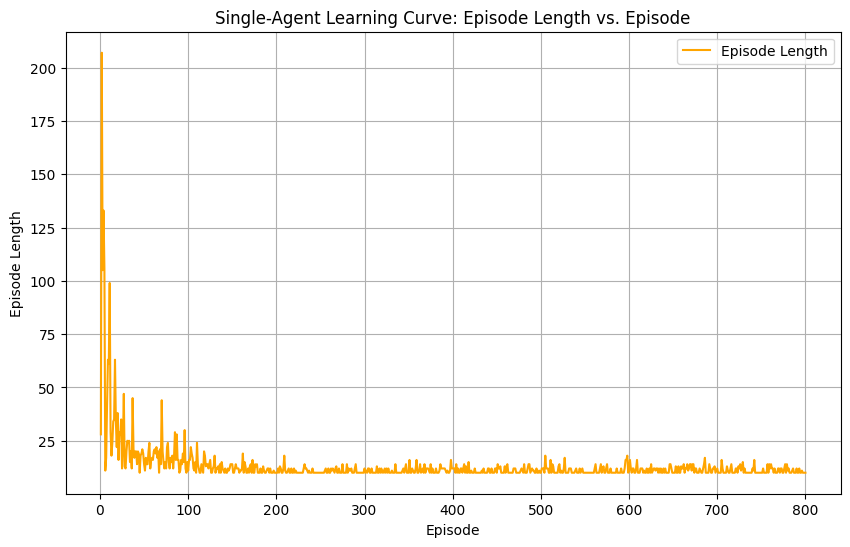

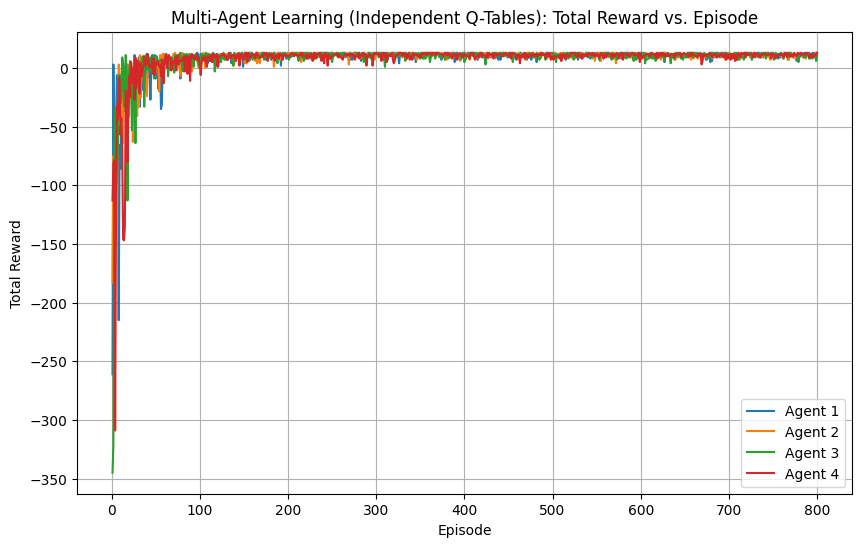

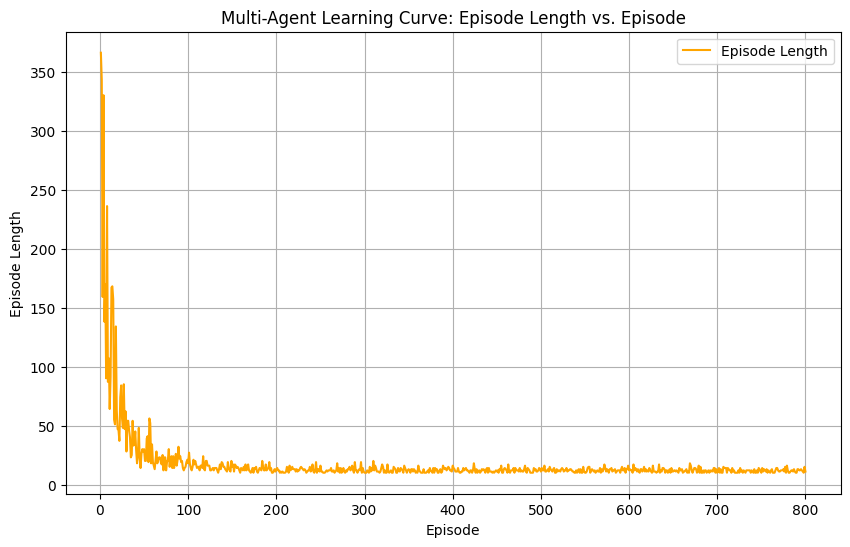

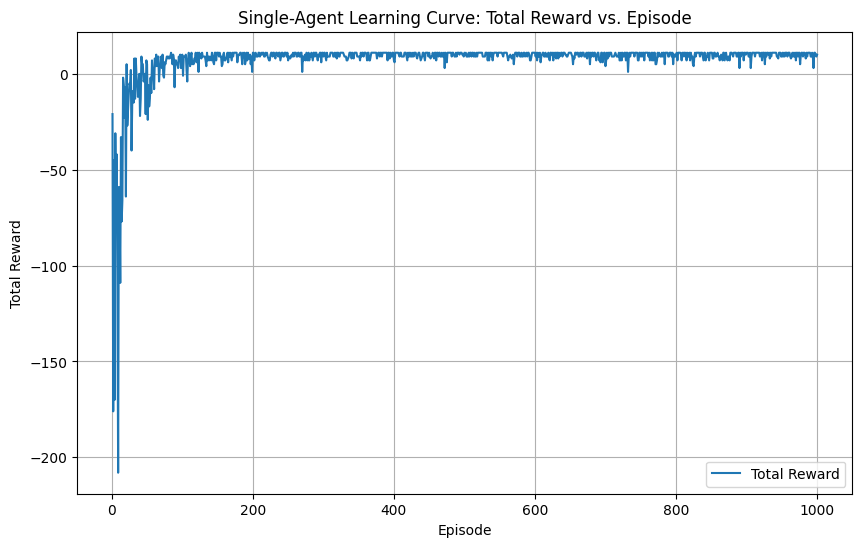

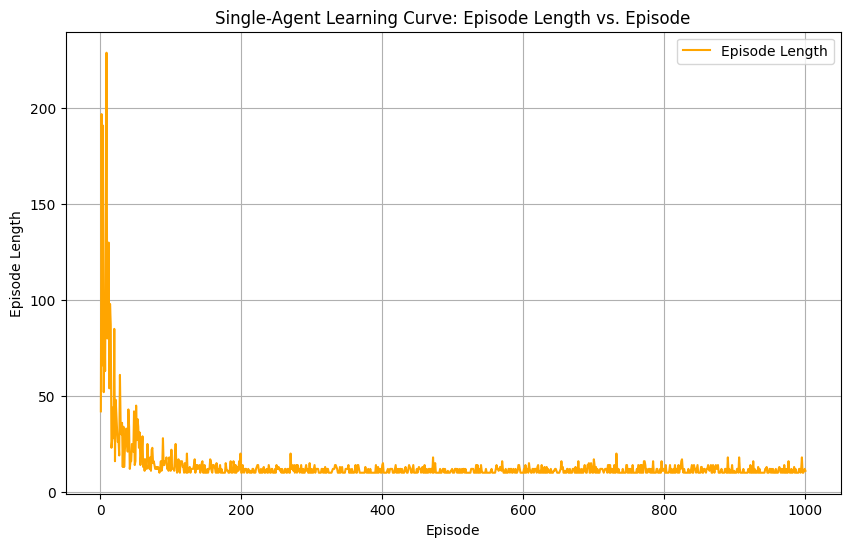

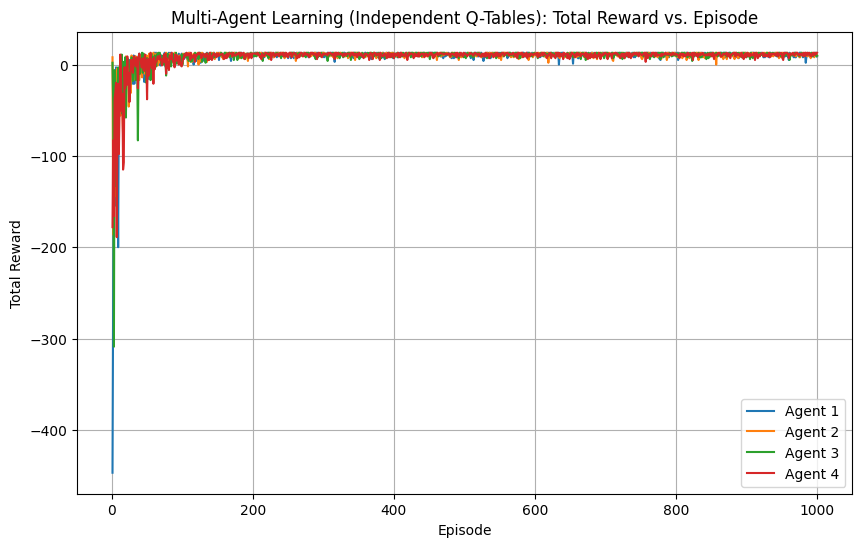

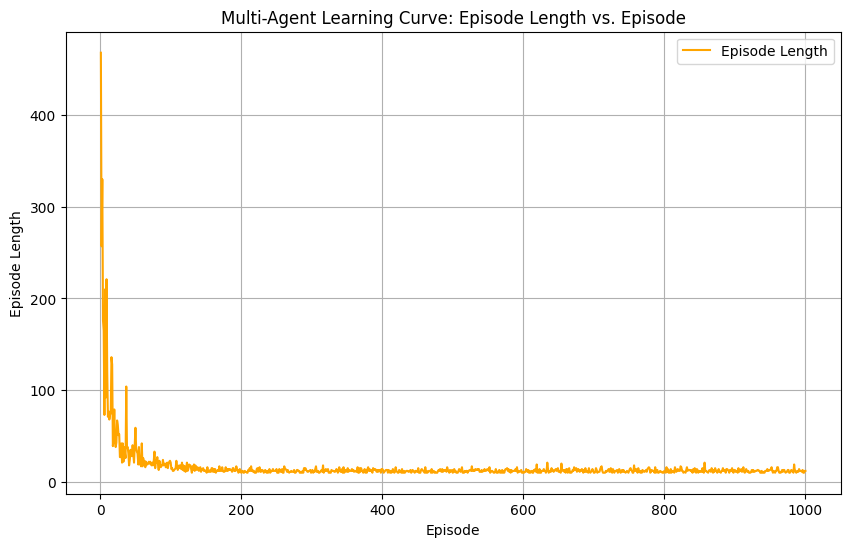

In [106]:
# running the analysis on the 200 episode simulations
analyze_results("single_agent_results_200.csv", "multi_agent_results_200.csv")

# running the analysis on the 800 episode simulations
analyze_results("single_agent_results_800.csv", "multi_agent_results_800.csv")

# running the analysis on the 1000 episode simulations
analyze_results("single_agent_results_1000.csv", "multi_agent_results_1000.csv")